In [ ]:
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [ ]:
!pip install --no-deps '../input/timm0130/timm-0.1.30-py3-none-any.whl' > /dev/null

In [ ]:
import sys
import os
sys.path.insert(0, "../input/timm-efficientdet-pytorch-v1-3-0/efficientdet-pytorch-master")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim
import gc
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
import glob
import random
import time
from datetime import datetime
import ensemble_boxes
from ensemble_boxes import *
from itertools import product
%matplotlib inline
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from albumentations import (Blur, MotionBlur, MedianBlur, GaussianBlur,
                            VerticalFlip, HorizontalFlip, IAASharpen,
                            OneOf, Compose , BboxParams, Resize, HueSaturationValue
                            ,RandomBrightnessContrast, ToGray , Cutout ,  RandomSizedCrop)

In [ ]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain , DetBenchPredict
from effdet.efficientdet import HeadNet

**Path directories**

In [ ]:
DIR_PATH = '../input/global-wheat-detection/'
dir = glob.glob(os.path.join(DIR_PATH , '*'))
dir.sort(reverse=True)
print(dir)
train_paths = glob.glob(os.path.join(dir[1] , '*'))
test_paths = glob.glob(os.path.join(dir[2] , '*'))

In [ ]:
df = pd.read_csv(dir[0])
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds

In [ ]:
df_folds.groupby('fold')['bbox_count'].mean()

# **Help functions**

In [ ]:
def show_image(image, boxes, title):
  fig, ax = plt.subplots(1, 1, figsize=(25, 8))
  boxes = boxes.astype(np.int32)
  for box in boxes:
      cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 3)
  ax.set_title(title) 
  ax.set_axis_off()
  ax.imshow(image);


def load_image_and_boxes(image_path):
  image_id = image_path.split('/')[-1].split('.')[0]
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  records = df[df['image_id'] == image_id]
  boxes = records[['x', 'y', 'w', 'h']].values
  boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
  boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
  return image, boxes


def images_after_augmentation(original_image, boxes, augmentation):
    aug_image = original_image.copy()
    boxes = boxes.astype(np.int32)
    if isinstance(augmentation , VerticalFlip) or isinstance(augmentation , HorizontalFlip):
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
    else:
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
    plt.figure(figsize=[12, 12])
    for i in range(len([original_image, aug_image])):
            image = [original_image, aug_image][i]
            plt.subplot(1, 2, i+1)
            plt.title(['Original Image', 'After Augmentaion'][i])
            plt.axis("off")
            plt.imshow(image)
    plt.show()


# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


BOX_COLOR = (255, 255, 0)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=3):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax =  int(xmin), int(ymin), int(xmax), int(ymax)
    cv2.rectangle(img, (xmin , ymin), (xmax, ymax), color=BOX_COLOR, thickness=thickness)
    return img

def visualizeTarget(image, target , visualize_data_loader = True):
  boxes = target['boxes']
  if visualize_data_loader:
    if not type(boxes).__module__ == np.__name__:
      boxes = boxes.numpy()
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
  img = image.copy()
  for idx, bbox in enumerate(boxes):
      img = visualize_bbox(img, bbox)
  return img

# **Examples**

In [ ]:
image_id = '8425a537b.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image without bounding box")

In [ ]:
image_id = 'b3c96d5ad.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image with bounding box")

**Examples of some augmentations that we will use for our train**

**Blur**

In [ ]:
images_after_augmentation(image, boxes, Blur(blur_limit=7 ,p=1))

# **Vertical Flip**

In [ ]:
images_after_augmentation(image, boxes, VerticalFlip(p=1))

# **Horizontal Flip**

In [ ]:
images_after_augmentation(image, boxes, HorizontalFlip(p=1))

# **Wheat dataset**

In [ ]:
class WheatDataset(Dataset):
    def __init__(self , dataframe , image_ids,  transforms = None):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.transforms = transforms


    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
    
        image, boxes = self.load_image_and_boxes(index)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
 
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
    
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                        'image': image,
                        'bboxes': target['boxes'],
                        'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['labels'] = torch.stack(sample['labels'])
                    break
        return image, target, image_id
              
      
    def __len__(self) -> int:
        return self.image_ids.shape[0]


    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[1]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        area = (boxes[:, 2] * boxes[:, 3])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

# **Augmentations**

In [ ]:
transforms_train = Compose([IAASharpen(p = 0.5), RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),ToGray(p=0.01),
                            OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                                    RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.9)],p=0.8),
                            OneOf([Blur(blur_limit=3), MotionBlur(blur_limit=3), MedianBlur(blur_limit=3)]),
                            OneOf([VerticalFlip(), HorizontalFlip()]),
                            Cutout(num_holes=10, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                            Resize(height=512, width=512, p = 1.0)
                            ,ToTensorV2(p=1.0),
                            ],p = 1.0,bbox_params=BboxParams(format='pascal_voc', min_area=0, 
                                               min_visibility=0, label_fields=['labels']))


transforms_valid = Compose([Resize(height=512, width=512, p=1.0),
                            ToTensorV2(p=1.0),], p=1.0,
                            bbox_params=BboxParams(
                                format='pascal_voc',
                                min_area=0,
                                min_visibility=0,
                                label_fields=['labels']))

# **Data Loader**

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
bs = 2
fold_number = 0

train_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] != fold_number].index.values , transforms=transforms_train)
valid_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] == fold_number].index.values , transforms=transforms_valid)

train_loader = DataLoader(train_set,batch_size = bs,sampler=RandomSampler(train_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=2)
valid_loader = DataLoader(valid_set,batch_size = bs ,sampler=SequentialSampler(valid_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=2)

images , targets , path_images = next(iter(train_loader))
img = visualizeTarget(images[0],targets[0])
visualize(Example_one_image_from_dataloader = img)

# **Train/Validation**

In [ ]:
class Calculator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class Training:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.best_calc_loss = 10**5

        self.model = model
        self.device = device


        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)


    def train_loop(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            calc_loss = self.train_one_epoch(train_loader)

            print(f'Train. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save_model(f'{self.base_dir}/last-epoch.bin')

            t = time.time()
            calc_loss = self.valid_one_epoch(validation_loader)

            print(f'Val. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if calc_loss.avg < self.best_calc_loss:
                self.best_calc_loss = calc_loss.avg
                self.model.eval()
                self.save_model(f'{self.base_dir}/best-model-{str(self.epoch).zfill(3)}epoch.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=calc_loss.avg)

            self.epoch += 1


    def train_one_epoch(self, train_loader):
        self.model.train()
        calc_loss = Calculator()
        t = time.time()
        target_res = {}
        for images, targets, image_ids in tqdm_notebook(train_loader):
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels  

            self.optimizer.zero_grad()

            outputs = self.model(images, target_res)
            loss = outputs['loss']
            calc_loss.update(loss.detach().item(), batch_size)
        
            loss.backward()
            self.optimizer.step()

            if self.config.step_scheduler:  
                self.scheduler.step()
      
        return calc_loss


    
    def valid_one_epoch(self, val_loader):
        self.model.eval()
        calc_loss = Calculator()
        t = time.time()
        
        with torch.no_grad():
            for images, targets, image_ids in tqdm_notebook(val_loader):
                images = torch.stack(images)
                images = images.to(self.device).float()
                batch_size = images.shape[0]
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
        
                outputs = self.model(images, target_res)
                loss = outputs['loss']
                calc_loss.update(loss.detach().item(), batch_size)
        return calc_loss


    def save_model(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_calc_loss': self.best_calc_loss,
            'epoch': self.epoch,
        }, path)


    def load_model(self, path):
        model = torch.load(path)
        self.model.load_state_dict(model['model_state_dict'])
        self.optimizer.load_state_dict(model['optimizer_state_dict'])
        self.scheduler.load_state_dict(model['scheduler_state_dict'])
        self.best_calc_loss = model['best_calc_loss']
        self.epoch = model['epoch'] + 1

# **EfficientDet_D5 Model**
`num_classes = 1` - only one class called wheat

In [ ]:
def get_model(num_classes = 1):
    config = get_efficientdet_config('tf_efficientdet_d5')
    model = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('/content/drive/My Drive/Global Wheat Detection/efficientdet_d7/efficientdet_d5-ef44aea8.pth')
    model.load_state_dict(checkpoint)
    config.num_classes = num_classes
    config.image_size = 512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(model, config)

In [ ]:
class GlobalParametersTrain:
    lr = 0.0002 
    n_epochs = 40 

    folder = '/content/drive/My Drive/Global Wheat Detection/efficientdet_d5'

    verbose = True
    verbose_step = 10

    step_scheduler = False 
    validation_scheduler = True 
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(mode='min',factor=0.5,patience=1,verbose=False, threshold=0.0001,threshold_mode='abs',cooldown=0, min_lr=1e-8,eps=1e-08)

**Load best efficientdet d5 model are trained**

In [ ]:
def load_model(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    model = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    model = DetBenchPredict(model, config)
    model.eval();
    return model.cuda()

model = load_model('../input/efficientdetd5model17e/efficient-best-017epoch.bin')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_predictions(images ,  score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        outputs = model(images , torch.tensor([1.0] * images.shape[0], dtype=torch.float).to(device) , torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))
        for i in range(images.shape[0]):
            boxes = outputs[i].detach().cpu().numpy()[:,:4]    
            scores = outputs[i].detach().cpu().numpy()[:,4]
            labels = outputs[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return [predictions]

# **Weighted Boxes Fusion**
**Why WBF can be better than NMS or SoftNMS?**

Both NMS and Soft-NMS exclude some boxes, but WBF uses information from all boxes. It can fix some cases where all boxes are predicted inaccurate by all models. NMS will leave only one inaccurate box, while WBF will fix it using information from all 3 boxes.

See the example in Fig. 1 , red predictions, blue ground truth.

Reference : https://arxiv.org/pdf/1910.13302.pdf

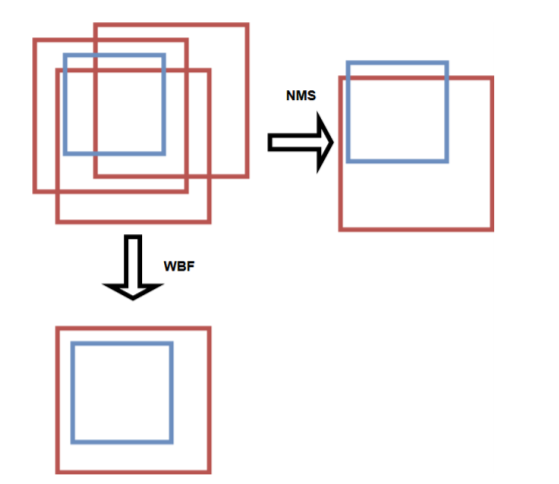

In [ ]:
def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    # labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break
predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

**Example from validation set of ground truth vs prediction**

In [ ]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{dir[1]}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    preds = (preds*2).astype(np.int32).clip(min=0, max=1023)
    gt_boxes = (gt_boxes*2).astype(np.int32).clip(min=0, max=1023)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (255, 255, 0), 3
        )
        
    for pred_box in preds:
        cv2.rectangle(sample,(pred_box[0], pred_box[1]),(pred_box[2], pred_box[3]),
            (255, 0, 0), 3)
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | YELLOW - Ground-truth")
# f5a1f0358
show_result(image_ids[0], boxes, targets[0]['boxes'].numpy())

# **TTA Classes**

In [ ]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# **Combinations of TTA**

In [ ]:
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], [TTAVerticalFlip(), None],[TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [ ]:
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda() ,  torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))

            for i in range(images.shape[0]):
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                labels = outputs[i].detach().cpu().numpy()[:,5]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                    'labels': labels[indexes],
                })
            predictions.append(result)
    return predictions

In [ ]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break


predictions = make_tta_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

# **Inference**

In [ ]:
test_transforms =  Compose([
            Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
class TestDataset(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[2]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
test_set = TestDataset(image_ids=np.array([path.split('/')[-1][:-4] for path in test_paths]),transforms=test_transforms)
test_loader = DataLoader(test_set,batch_size=4,shuffle=False,num_workers=2,drop_last=False,collate_fn=collate_fn)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [ ]:
submission = []

for images, image_ids in test_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        
        img = visualizeTarget(image, {'boxes' : boxes} , visualize_data_loader = True)
        visualize(test_image = img)
        
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        submission.append(result)

# **Submission**

In [ ]:
SUBMISSION_PATH = '/kaggle/working'
submission_id = 'submission'
submission_path = os.path.join(SUBMISSION_PATH, '{}.csv'.format(submission_id))
sample_submission = pd.DataFrame(submission, columns=["image_id","PredictionString"])
sample_submission.to_csv(submission_path, index=False)
submission_df = pd.read_csv(submission_path)
submission_df